# Google Art & Culture - Case study using CRISPS-DM

#### Autors: Manuel Alejandro Aponte, Cristian Beltran, Maria Paula Peña

In this notebook you will explore data and create classification models

## Objectives
The objective of this notebooks is:

* Visualize the data through graphs.
* test different classification model based in dataset
* Optimize model by means of hyperparameters.

## Prerequisites

* Familiarity with Python, Sklearn & Grid Search. 
* Install python packages.

## Background 
This notebook belongs to Google Art & Culture Case Study using CRIPS-DM, where would be include process such as webscraping, exploratory data analysis, ML classificators and dashboards.

# TODO: 

**EDA**

**NN for classification**

**Stratify cross validation**

**Metric** 

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries 📚

In [47]:
#Import global packages
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

#Import local packages
from src.paths.paths import PATHS, create_folder

#Configure print settings
np.set_printoptions(precision=3, suppress=True)
warnings.filterwarnings("ignore")

In [48]:
file_pictures = PATHS['data_final'] /"pictures.csv"

## Load data

In [49]:
df = pd.read_csv(file_pictures)
df.head(5)

,index,category,filename,Title,Date Created,Dimensions,Artist,h_mean,s_mean,v_mean,mean_grayscale,mean_blue,mean_green,mean_red,std_grayscale,std_blue,std_green,std_red
0,0,WHITE,0.jpg,"Symphony in White, No. 1 The White Girl",1862,overall 213 x 107.9 cm (83 7/8 x 42 1/2 in.) ...,James McNeill Whistler,0.111021,0.228014,0.759860,0.707468,0.592548,0.702255,0.759860,0.113919,0.112658,0.117957,0.108062
1,1,WHITE,1.jpg,The Cradle,1872,w460 x h560 cm,Berthe Morisot,0.114576,0.181637,0.627300,0.591144,0.519539,0.586287,0.626952,0.204013,0.186520,0.203947,0.212146
2,2,WHITE,2.jpg,The Magpie,1868 - 1869,w1300 x h890 mm,Claude Monet,0.166317,0.100085,0.706963,0.687141,0.638097,0.687555,0.704309,0.133684,0.122419,0.133433,0.139909
3,3,WHITE,3.jpg,Summer evening on Skagen Sønderstrand,1893,100 × 150 cm,Peder Severin Krøyer,0.355944,0.136984,0.745947,0.696685,0.713158,0.700890,0.682375,0.119145,0.071436,0.113651,0.153838
4,4,WHITE,4.jpg,"Composition with red, yellow and blue",1927,40 x 52 cm,Piet Mondriaan,0.152400,0.134496,0.874091,0.836621,0.802547,0.829830,0.862469,0.246921,0.279878,0.261812,0.241762


In [50]:
y = df['category']
X = df[['h_mean','s_mean','v_mean','mean_grayscale','mean_blue','mean_green','mean_red','std_grayscale','std_blue','std_green','std_red']] 

# Preprocesing Data

**Apply encoding to categories and scale features**

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#Create preprocessing objects
le = LabelEncoder()
sc = StandardScaler()


#Transform categories into nominal data
y= le.fit_transform(y)

#Apply Standard Scaler to X
scaler = sc.fit(X)
X = scaler.transform(X)

In [52]:
y

array([9, 9, 9, ..., 0, 0, 0])

**Export label_encoder and Scaler**

In [53]:
dump(le, PATHS['models']/'label_encoder.joblib')
dump(le, PATHS['models']/'scaler.joblib')



['d:\\Portfolio\\Engineer\\computer science\\machine_learning_git\\clasification\\Google Art and Culture\\models\\scaler.joblib']

# EDA 📊

**Explore RGB **

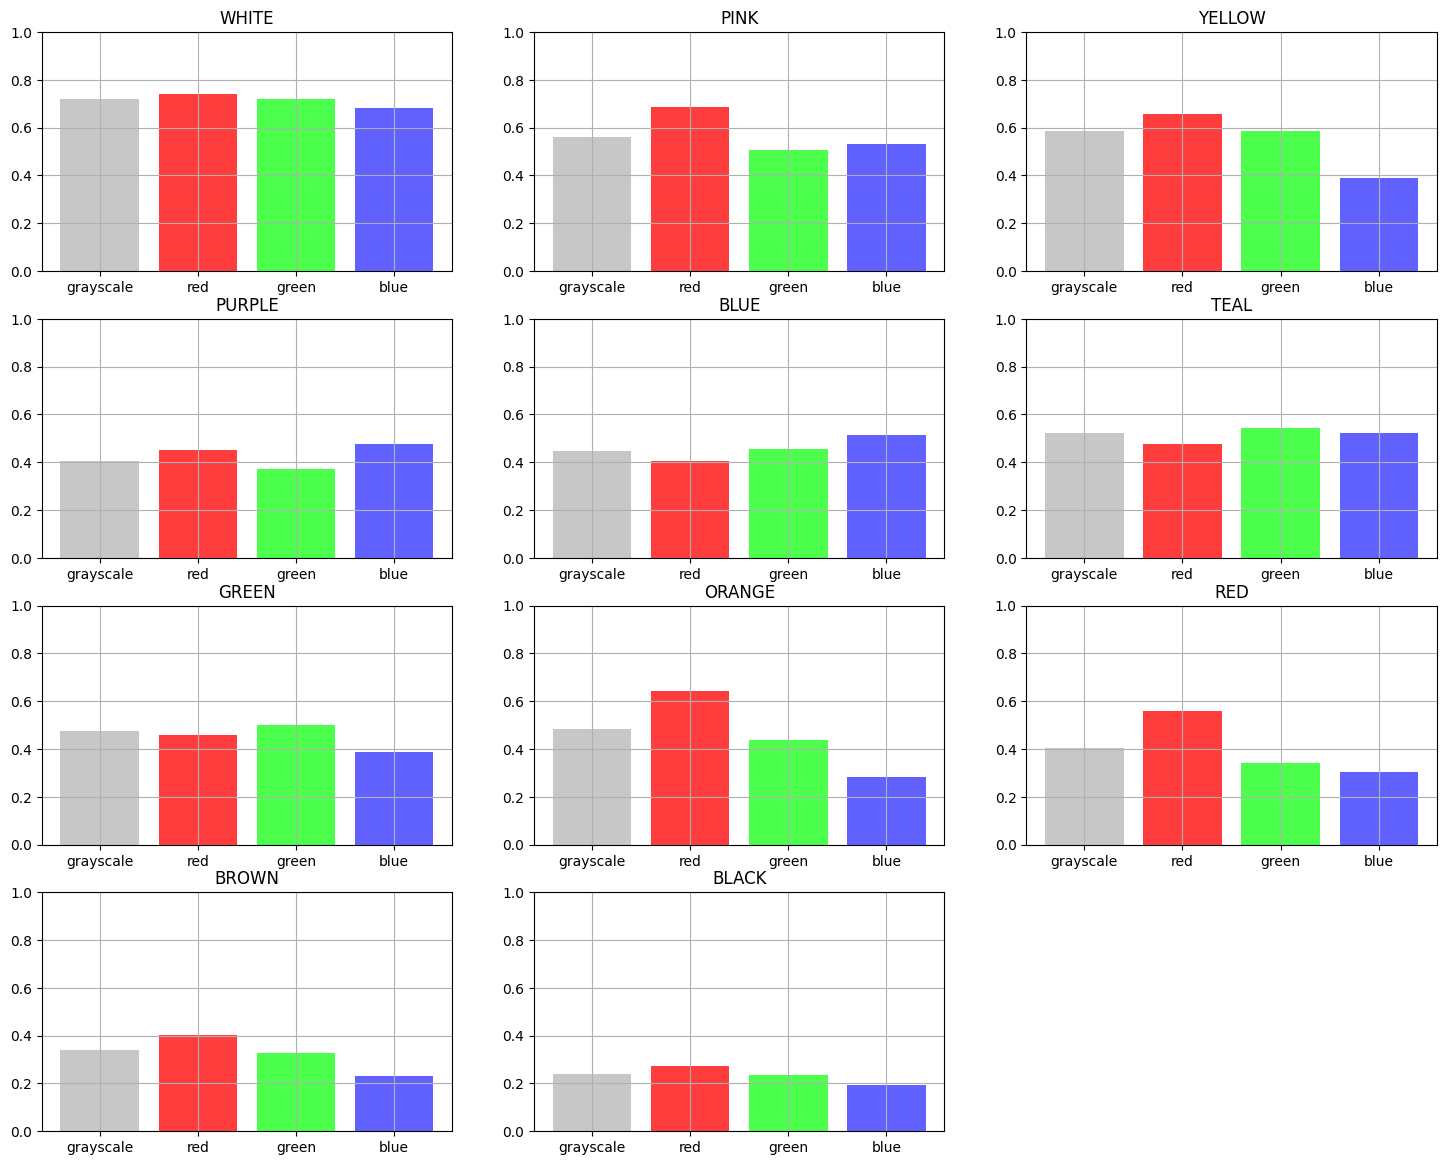

In [43]:
plt.figure(figsize=(18, 18))

for i,category in enumerate(df['category'].unique()):
    category_df = df[df['category']==category]
    color_values = category_df[['mean_grayscale','mean_red', 'mean_green','mean_blue']].mean()
    plt.subplot(5, 3, i+1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.bar(['grayscale','red','green','blue'],color_values ,color =['#C7C7C7','#FF3D3D','#4DFF4D','#6161FF'])
    plt.title(category)





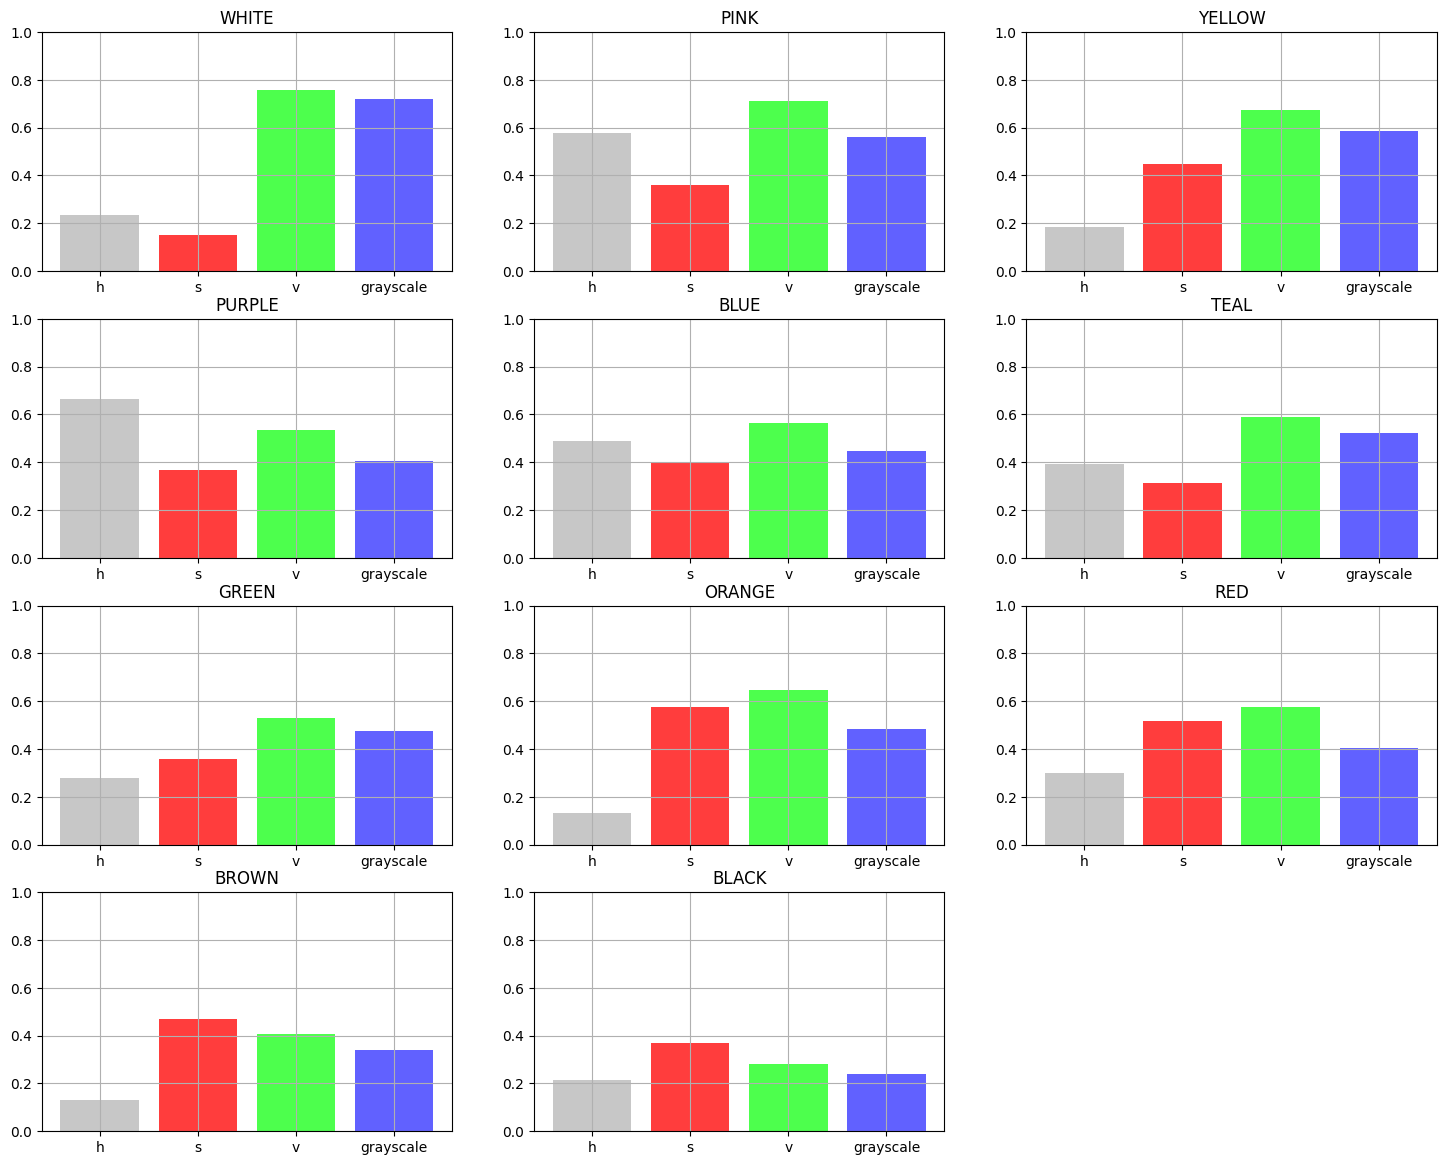

In [40]:
plt.figure(figsize=(18, 18))

for i,category in enumerate(df['category'].unique()):
    category_df = df[df['category']==category]
    color_values = category_df[['h_mean','s_mean', 'v_mean', 'mean_grayscale']].mean()
    plt.subplot(5, 3, i+1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.bar(['h','s', 'v', 'grayscale'],color_values ,color =['#C7C7C7','#FF3D3D','#4DFF4D','#6161FF'])
    plt.title(category)

# EDA

Text(0.5, 1.0, 'Features correlation')

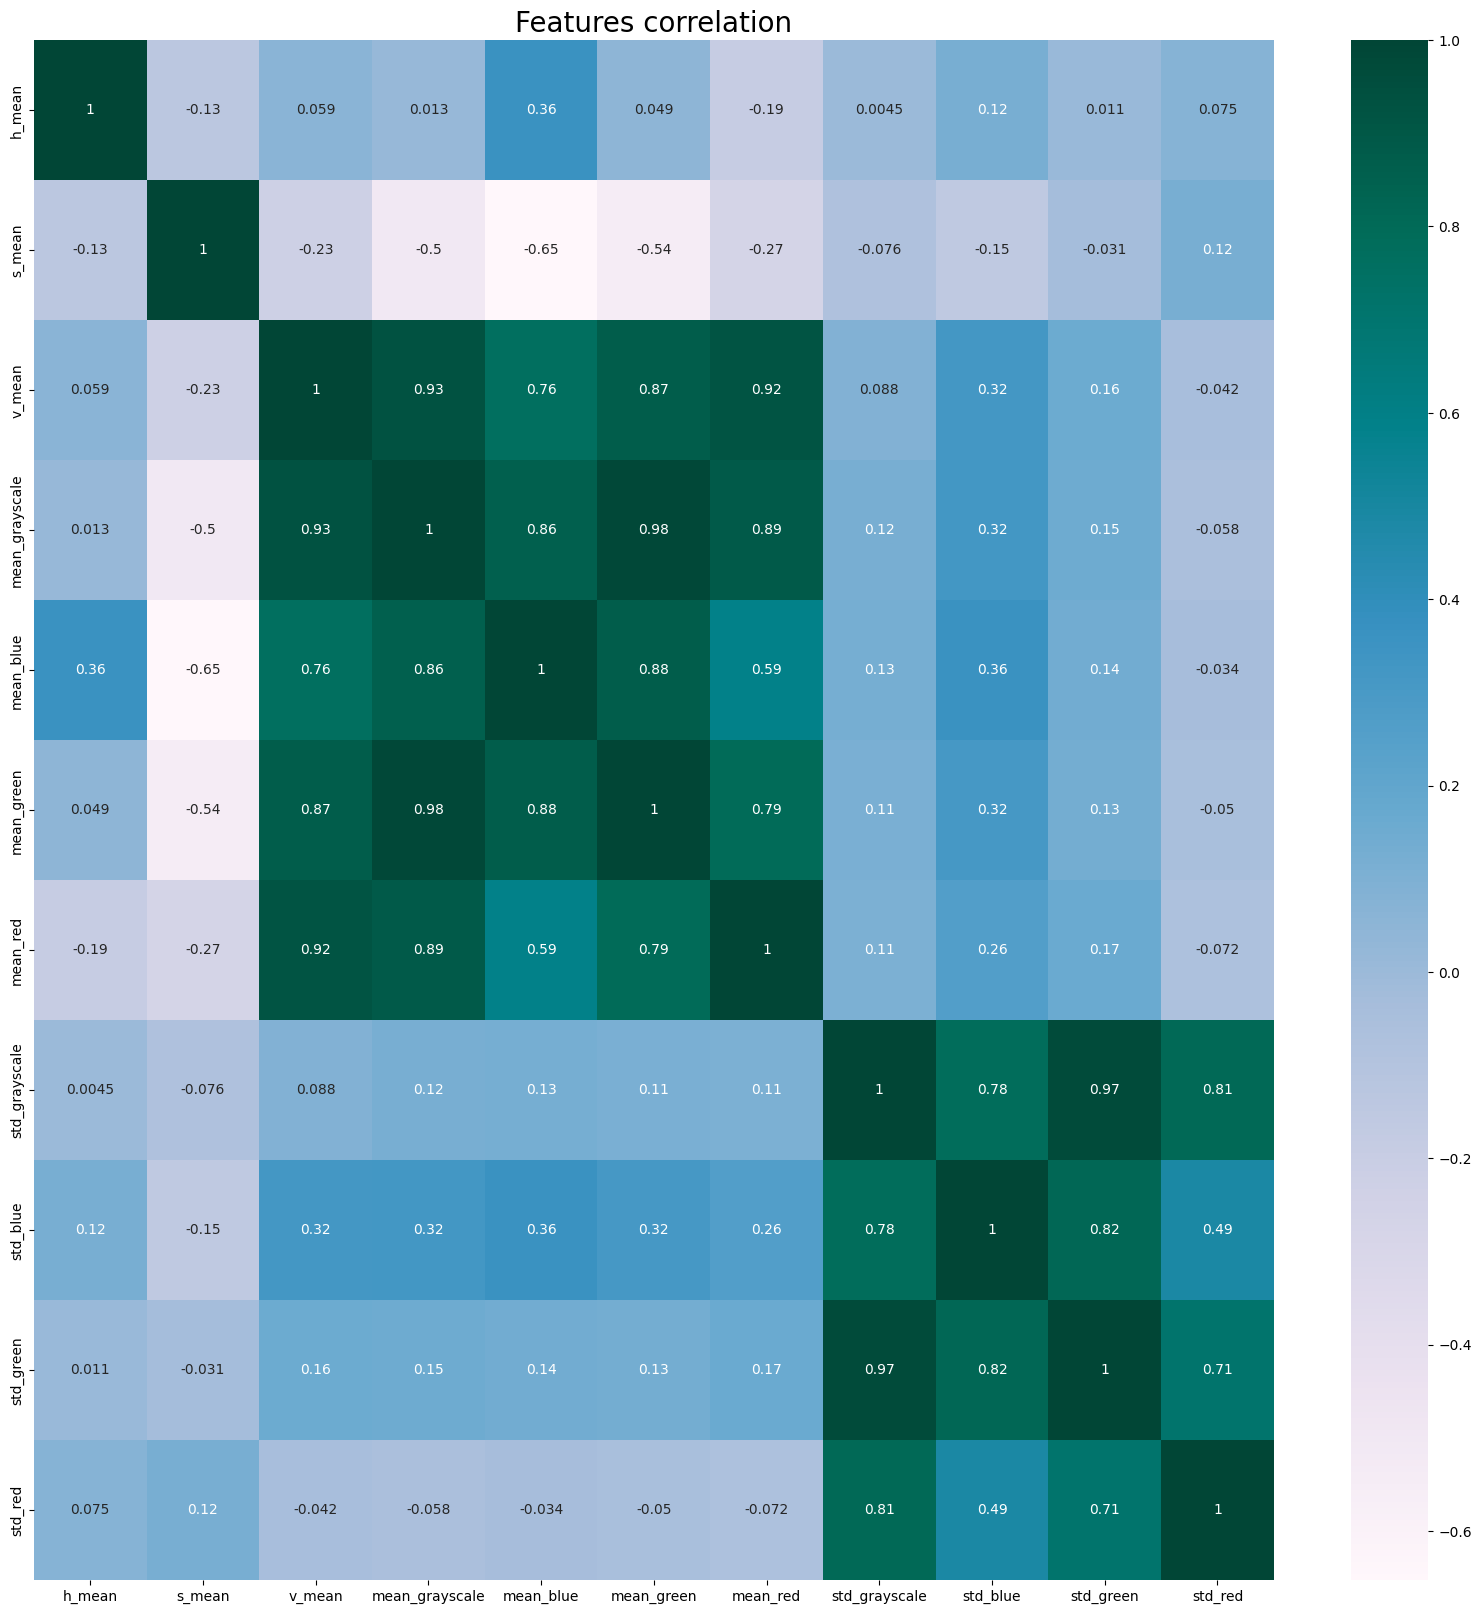

In [7]:
plt.figure(figsize=(20,20))
hm=sns.heatmap(X.corr(),cmap="PuBuGn",annot=True)
hm.set_title('Features correlation', fontdict={'fontsize':20})

### Considerations

* The differents types of std (grayscale, blue, green and red) are very correlated between them , so std_blue, std_green, std_red will be deleted
* mean_grayscale produces high correlation with mean_blue, mean_green and mean_red, so mean_grayscale will be deleted

## Models 📈

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


def model_pipeline(X, y,n_jobs):
    

    default_params = {'random_state':42}    
    log_reg = LogisticRegression(**default_params|{'n_jobs':-1})
    knn = KNeighborsClassifier()
    svm = SVC(**default_params)
    NN = MLPClassifier(**default_params|{'hidden_layer_sizes':(526,526),'max_iter':400,'activation':'relu'
                        ,'n_iter_no_change':400,'learning_rate':'adaptive','batch_size':1000
                        ,'validation_fraction':0.15,'early_stopping':True})
        
    models = [
            ('logistic_regression', log_reg, {"penalty":['l2','none'], 'C':np.logspace(-4, 2, num=2)}), 
            ('k_nearest_neighbors', knn, {'n_neighbors':[3,9,12], 'metric': ['l1','l2']}), 
            ('svm', svm, {'C': np.logspace(-1, 5, num=7),'gamma': np.logspace(-4, 0, num=5), 'kernel':['rbf','linear']}),
            ('neural_network',NN, {'alpha':[0.5]} )
            ]
    
    results = pd.DataFrame(columns=['model','params','mean_test_score'])
    for name,model,params in models:
        print('Training:',name)
        classifier = GridSearchCV(model,params,cv=3,return_train_score=False,n_jobs=n_jobs,verbose=3)
        classifier.fit(X,y)
        full_report = pd.DataFrame(classifier.cv_results_)
        full_report['model']= name
        report = full_report[['model','params','mean_test_score','mean_fit_time']]
        results = pd.concat([results, report])
        
        model_export_name = f'{name}.joblib'
        dump(classifier, PATHS['models']/model_export_name)
        
    results = results.reset_index(drop=True)
    return results


In [58]:
print('------All features------')
model_df = model_pipeline(X,y,-1)

------All features------
Training: logistic_regression
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Training: k_nearest_neighbors
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Training: svm
Fitting 3 folds for each of 4 candidates, totalling 12 fits


# Model Selection

In [59]:
model_df.sort_values('mean_test_score',ascending=False).head(15)
#['params'].to_list()

,model,params,mean_test_score,mean_fit_time
12,svm,"{'C': 100000.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.845728,1.266562
1,logistic_regression,"{'C': 0.0001, 'penalty': 'none'}",0.831729,0.323670
3,logistic_regression,"{'C': 100.0, 'penalty': 'none'}",0.831729,0.329997
2,logistic_regression,"{'C': 100.0, 'penalty': 'l2'}",0.830077,0.329999
13,svm,"{'C': 100000.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.795664,7.229946
11,svm,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.707689,1.345229
6,k_nearest_neighbors,"{'metric': 'l1', 'n_neighbors': 12}",0.705842,0.026665
5,k_nearest_neighbors,"{'metric': 'l1', 'n_neighbors': 9}",0.705648,0.018998
9,k_nearest_neighbors,"{'metric': 'l2', 'n_neighbors': 12}",0.701565,0.018665
8,k_nearest_neighbors,"{'metric': 'l2', 'n_neighbors': 9}",0.700204,0.018665


### Search the models with best test scores

In [60]:
#models_df.loc[models_df.reset_index().groupby('model', as_index=False).agg('max').idxmax()]
model_df.loc[model_df.groupby('model')['mean_test_score'].idxmax()].sort_values('mean_test_score',ascending=False)

,model,params,mean_test_score,mean_fit_time
12,svm,"{'C': 100000.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.845728,1.266562
1,logistic_regression,"{'C': 0.0001, 'penalty': 'none'}",0.831729,0.323670
6,k_nearest_neighbors,"{'metric': 'l1', 'n_neighbors': 12}",0.705842,0.026665


In [30]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
#https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
# https://en.wikipedia.org/wiki/Radial_basis_function_kernel

In [47]:
#len(model_all_features_df)
model_all_features_df.groupby('model').sum()

,mean_test_score,mean_fit_time
model,,
k_nearest_neighbors,4.336250,0.083001
logistic_regression,2.653154,3.005336
neural_network,17.372995,193.254924
svm,51.485078,211.744771


In [17]:
print('r:',(3,)*5)

r: (3, 3, 3, 3, 3)


In [ ]:
'''

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2,stratify=y,random_state=41)
sc=StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)
#trainX_scaled = trainX
#testX_scaled = testX
print('len:',len(trainX_scaled))
NN =MLPClassifier(hidden_layer_sizes=(526,526),
                  max_iter = 400,activation = 'relu',
                  random_state=42, n_iter_no_change=400,
                  learning_rate='adaptive',verbose=True,alpha=0.5, batch_size=1000,
                  validation_fraction=0.15,early_stopping=True)
#NN =MLPClassifier(hidden_layer_sizes=(25,)*10,random_state=42,)
NN.fit(trainX_scaled, trainY)
print(NN.loss_)

y_pred = NN.predict(testX_scaled)

print('Accuracy: {:.3f}'.format(accuracy_score(testY, y_pred)))

Accuracy: 0.87

'''

In [13]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['category']])
y_one_hot = enc.transform(df[['category']]).toarray()

In [18]:
len(X)

10287

In [39]:


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

trainX, testX, trainY, testY = train_test_split(X, y_one_hot, test_size = 0.2,stratify=y,random_state=41)
#sc=StandardScaler()
#sc = RobustScaler()

#scaler = sc.fit(trainX)
#trainX_scaled = scaler.transform(trainX)
#testX_scaled = scaler.transform(testX)
#trainX_scaled = trainX
#testX_scaled = testX
print('len:',len(X))
NN =MLPClassifier(hidden_layer_sizes=(100,100,100),
                  max_iter = 5000,activation = 'relu',
                  random_state=42, n_iter_no_change=200,
                  learning_rate='adaptive',verbose=True,alpha=0, batch_size=200,
                  validation_fraction=0.15,early_stopping=False)

NN.fit(trainX, trainY)
print(NN.loss_)

y_pred = NN.predict(testX)

print('Accuracy: {:.3f}'.format(accuracy_score(testY, y_pred)))

len: 10287
Iteration 1, loss = 6.37594023
Iteration 2, loss = 3.84262367
Iteration 3, loss = 2.98382610
Iteration 4, loss = 2.59663593
Iteration 5, loss = 2.30401406
Iteration 6, loss = 2.07919516
Iteration 7, loss = 1.91188505
Iteration 8, loss = 1.78882063
Iteration 9, loss = 1.69314238
Iteration 10, loss = 1.61216938
Iteration 11, loss = 1.54362768
Iteration 12, loss = 1.47923965
Iteration 13, loss = 1.42216046
Iteration 14, loss = 1.37075202
Iteration 15, loss = 1.32459655
Iteration 16, loss = 1.28486900
Iteration 17, loss = 1.24583421
Iteration 18, loss = 1.21569477
Iteration 19, loss = 1.18732870
Iteration 20, loss = 1.16280993
Iteration 21, loss = 1.14261696
Iteration 22, loss = 1.12409979
Iteration 23, loss = 1.10344359
Iteration 24, loss = 1.08661076
Iteration 25, loss = 1.07011609
Iteration 26, loss = 1.05711680
Iteration 27, loss = 1.04265632
Iteration 28, loss = 1.02934938
Iteration 29, loss = 1.01854290
Iteration 30, loss = 1.00527915
Iteration 31, loss = 0.99280732
Iterat

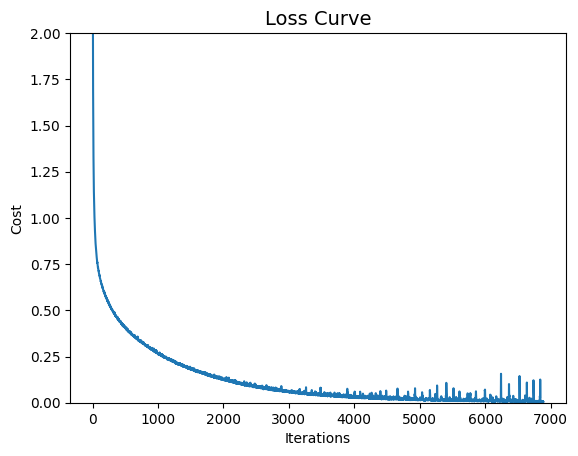

In [38]:
plt.plot(NN.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.ylim(0, 2)
plt.show()

In [391]:
print(np.abs(NN.coefs_[1]).sum())
print(np.count_nonzero(np.round(NN.coefs_[1],4)==0))

528.162544581591
996


In [24]:
#dir(NN)
#NN._compute_loss_grad

<bound method BaseMultilayerPerceptron._compute_loss_grad of MLPClassifier(hidden_layer_sizes=64, max_iter=300, solver='lbfgs')>

Accuracy: 0.82
